# Evaluation of DenseNet-121 and EfficientNet-B0 on Plant Village data


In [235]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

Load data from training

In [236]:
# for DenseNet-121
data_path = f'data_evaluation/densenet121/densenet121'
densenet_finetuned = pd.read_csv(f'{data_path}_finetune_history.csv', index_col='epoch')
densenet_head = pd.read_csv(f'{data_path}_head_history.csv',index_col='epoch')

# for EfficientNet-B0
data_path = f'data_evaluation/efficientnet_b0/efficientnet_b0'
efficientnet_finetuned = pd.read_csv(f'{data_path}_finetune_history.csv',index_col='epoch')
efficientnet_head = pd.read_csv(f'{data_path}_head_history.csv',index_col='epoch')

efficientnet_head[:5]

,train_loss,train_acc,val_loss,val_acc,lr
epoch,,,,,
1,0.726498,0.845065,0.246520,0.941350,0.001
2,0.289336,0.924017,0.178924,0.953043,0.001
3,0.234661,0.934329,0.154008,0.956450,0.001
4,0.208548,0.939669,0.133601,0.961882,0.001
5,0.192616,0.944365,0.133952,0.959580,0.001


                                                                                 Analytics of Training                                                                                 

Analytics of performance of two models DenseNet-121 and EfficientNet-B0 we will begin by analysing loss curves from training and evaluation per transfer learning strategy and then comparing two models by plotting generalisetion gap (difference between two loss functions).

During training were used two strategies:
> **Head-Only Training (Feature Extraction)**
<br>Idea of this strategy is to freeze all "backbone" layers like the pre-trained part of model that can already classify shapes, pattern taken from ImageNet. So only the final classification layer - head - is adapting parameter during training. 

> **Fine-Tuning Training (Last Block)**
<br>Idea of this control of training is to unfreeze the last few layers of the "backbone" whilst all earlier layers are frozen. This given an opportunity to teach model some  specific features. So in this case model adapts its high-level understanding to our specific plants rather then to generalised classification. 

Define helper function to handle compex graphs

In [237]:
def plot_training_analytics(df:list[pd.DataFrame], ax, *metrics:str, title:str='', axis_labels:list[str]=None, labels:list[str]=None):
    """
    df - can be single DataFrame or list of DataFrame
    ax - ax from plt
    *metrics - list of metrics what to plot
    title - define title for plot 
    axis_labels - [label_x, label_y] to plot specific labels for axes
    labels - to lable specificly each plotted data
    """
    for metric in metrics:
        for i, df in enumerate(df if type(df)==list else [df]):
            ax.plot(df.index, df[metric], label=labels[i] if labels else metric, marker='o')
            
            if axis_labels: 
                ax.set_xlabel(axis_labels[0])
                ax.set_ylabel(axis_labels[1])
        
            ax.set_title(title, fontweight='bold', fontsize=10)
            ax.grid(alpha=0.3)
            ax.legend()

Calculate generalisation gap (diffference between valuation loss curve and training loss)

In [238]:
for df in [densenet_finetuned, densenet_head, efficientnet_finetuned, efficientnet_head]:
    df['gap'] = df['val_loss'] - df['train_loss']

Plotting training strategy comparision

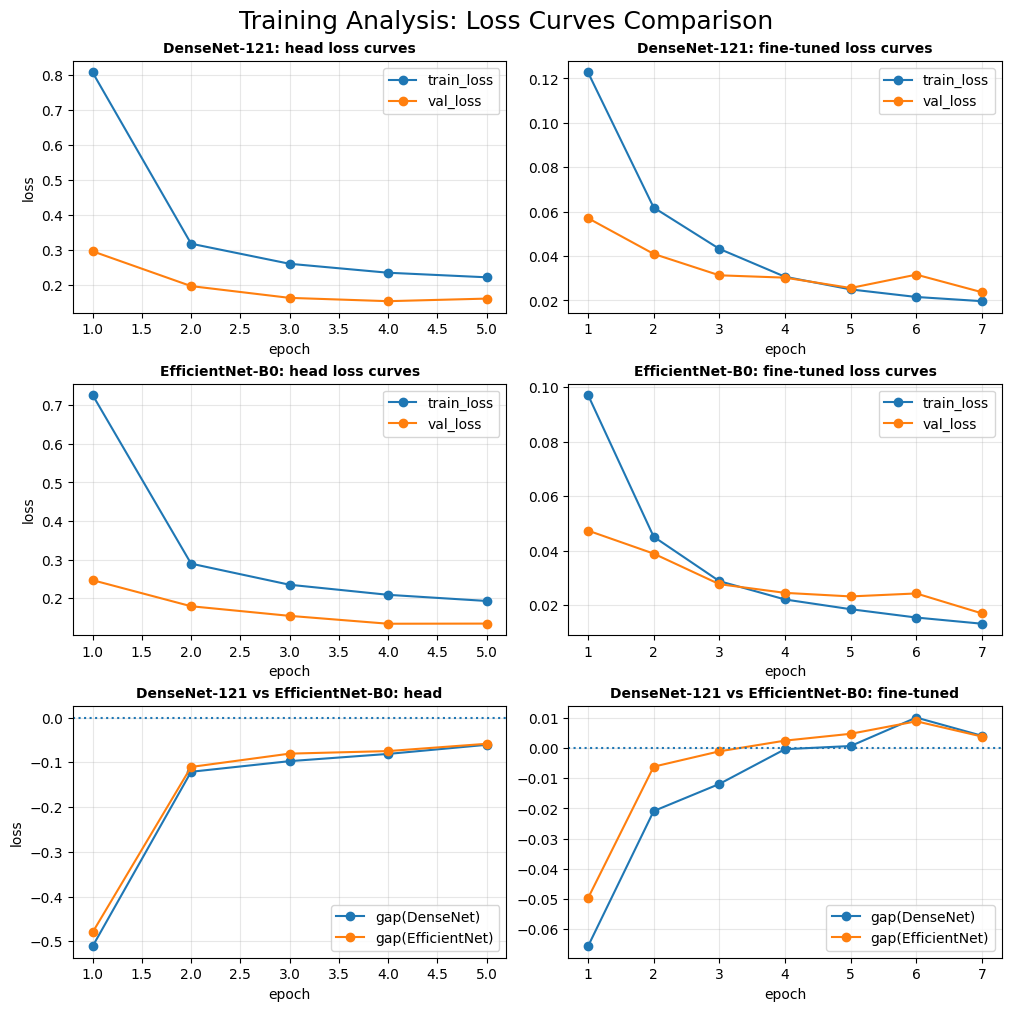

In [239]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10), layout="constrained") # additional parameter 'layout' automatically adjusts subplots -> not to have overlaps
fig.suptitle("Training Analysis: Loss Curves Comparison", fontsize=18)

# 1 head only desnet
plot_training_analytics(densenet_head, ax[0,0],'train_loss','val_loss',axis_labels=['epoch','loss'],title='DenseNet-121: head loss curves')

# 2 fine desnet
plot_training_analytics(densenet_finetuned, ax[0,1],'train_loss','val_loss',axis_labels=['epoch',''],title='DenseNet-121: fine-tuned loss curves')

# 3 head only efficientnet
plot_training_analytics(efficientnet_head, ax[1,0],'train_loss','val_loss',axis_labels=['epoch','loss'],title='EfficientNet-B0: head loss curves')

# 4 full only efficientnet
plot_training_analytics(efficientnet_finetuned, ax[1,1],'train_loss','val_loss',axis_labels=['epoch',''],title='EfficientNet-B0: fine-tuned loss curves')

# 5 gap -> densenet vs efficientnet -> head only
plot_training_analytics([densenet_head, efficientnet_head], ax[2,0],'gap',labels= ['gap(DenseNet)','gap(EfficientNet)'],axis_labels=['epoch','loss'],title='DenseNet-121 vs EfficientNet-B0: head')
ax[2,0].axhline(y=0,linestyle=':')

# 6 gap -> densenet vs efficientnet -> full
plot_training_analytics([densenet_finetuned, efficientnet_finetuned], ax[2,1],'gap',labels= ['gap(DenseNet)','gap(EfficientNet)'],axis_labels=['epoch',''],title='DenseNet-121 vs EfficientNet-B0: fine-tuned')
ax[2,1].axhline(y=0,linestyle=':') # add line y=0

plt.show()

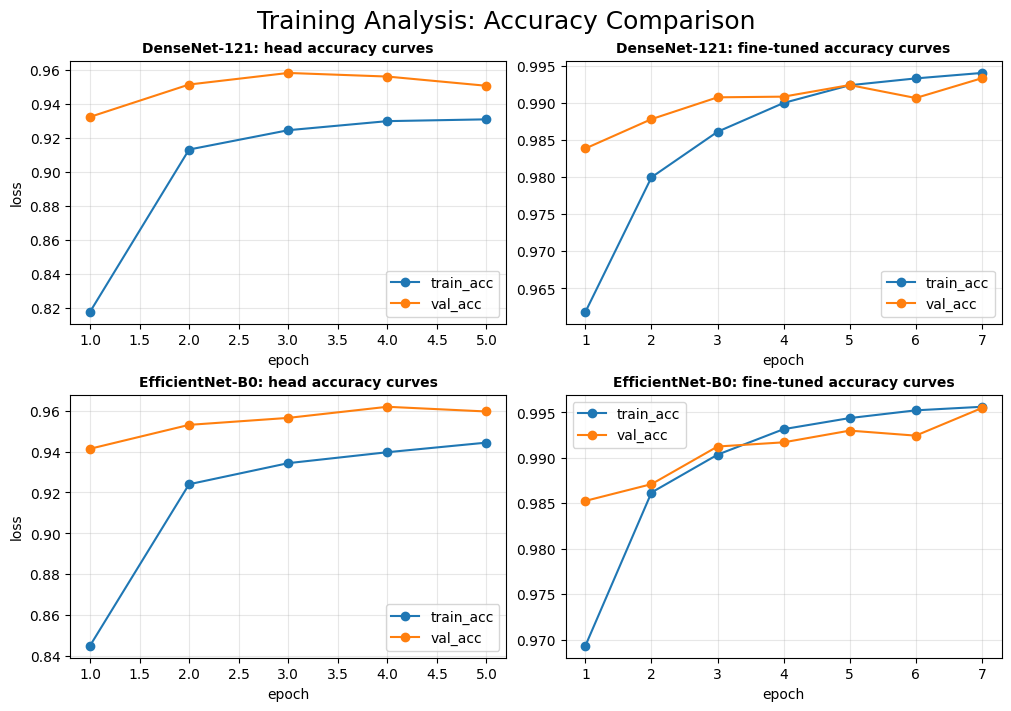

In [240]:
# compare learning speed + accuracy
fig, ax = plt.subplots(2, 2, figsize=(10, 7), layout="constrained")

fig.suptitle("Training Analysis: Accuracy Comparison", fontsize=18)

# 1 head only desnet
plot_training_analytics(densenet_head, ax[0,0],'train_acc','val_acc',axis_labels=['epoch','loss'],title='DenseNet-121: head accuracy curves')

# 2 fine desnet
plot_training_analytics(densenet_finetuned, ax[0,1],'train_acc','val_acc',axis_labels=['epoch',''],title='DenseNet-121: fine-tuned accuracy curves')

# 3 head only efficientnet
plot_training_analytics(efficientnet_head, ax[1,0],'train_acc','val_acc',axis_labels=['epoch','loss'],title='EfficientNet-B0: head accuracy curves')

# 4 full only efficientnet
plot_training_analytics(efficientnet_finetuned, ax[1,1],'train_acc','val_acc', axis_labels=['epoch',''],title='EfficientNet-B0: fine-tuned accuracy curves')

To optimise accuracy calculations let's collect title (model + training strategy) with its data

In [241]:
dfs = {
    "DenseNet-121 (head)": densenet_head,
    "DenseNet-121 (fine-tuned)": densenet_finetuned,
    "EfficientNet-B0 (head)": efficientnet_head,
    "EfficientNet-B0 (fine-tuned)": efficientnet_finetuned
}

In [252]:
# collect data into DataFrames
max_acc_dict = pd.DataFrame(columns=['model','max_train_acc', 'max_val_acc'])

for i, (name, df) in enumerate(dfs.items()): # name model - df
    max_train = df['train_acc'].max() * 100
    max_val = df['val_acc'].max() * 100
    
    max_acc_dict.loc[i] = [name, max_train, max_val] # store to df

#max_acc_dict.set_index('model')
max_acc_dict

,model,max_train_acc,max_val_acc
0,DenseNet-121 (head),93.089955,95.819906
1,DenseNet-121 (fine-tuned),99.408434,99.337078
2,EfficientNet-B0 (head),94.436516,96.188196
3,EfficientNet-B0 (fine-tuned),99.562655,99.548844


Put data in format for seaborn bar plot

In [243]:
df_melted = max_acc_dict.melt( # to restructure data
    id_vars="model", # keeps "model" fixed
    value_vars=["max_train_acc", "max_val_acc"], # selects data columns
    var_name="Accuracy_Type", #names category column
    value_name="Accuracy"#names value column
)
df_melted

,model,Accuracy_Type,Accuracy
0,DenseNet-121 (head),max_train_acc,93.089955
1,DenseNet-121 (fine-tuned),max_train_acc,99.408434
2,EfficientNet-B0 (head),max_train_acc,94.436516
3,EfficientNet-B0 (fine-tuned),max_train_acc,99.562655
4,DenseNet-121 (head),max_val_acc,95.819906
5,DenseNet-121 (fine-tuned),max_val_acc,99.337078
6,EfficientNet-B0 (head),max_val_acc,96.188196
7,EfficientNet-B0 (fine-tuned),max_val_acc,99.548844


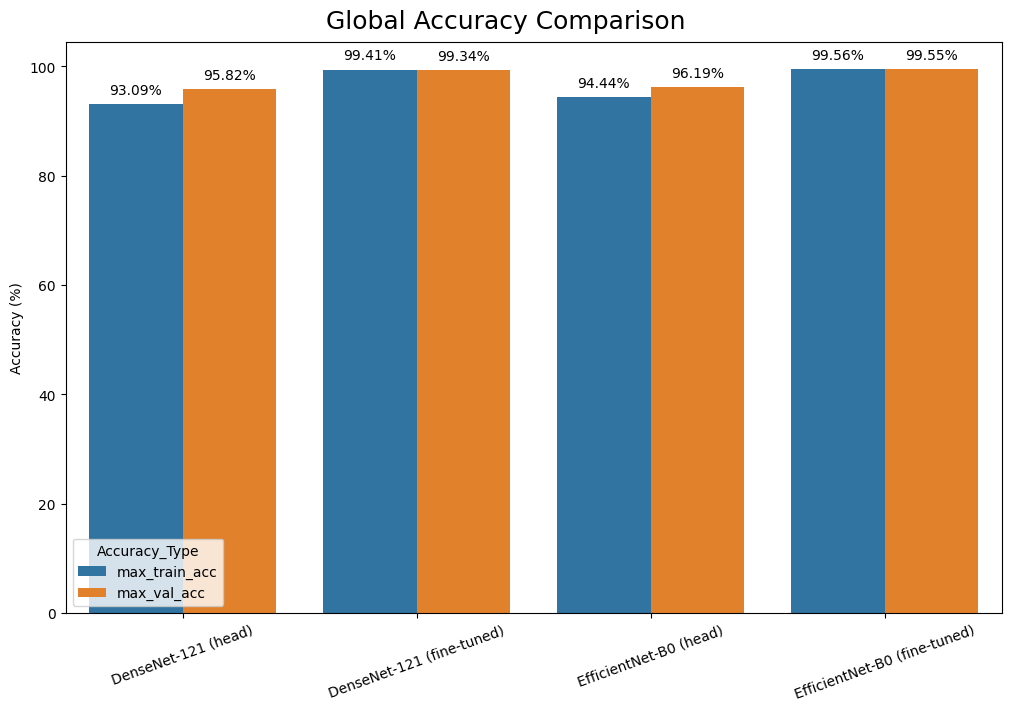

In [244]:
plt.figure(figsize=(10, 7), layout="constrained")
plt.suptitle("Global Accuracy Comparison", fontsize=18)

ax = sns.barplot(data=df_melted, x="model", y="Accuracy", hue="Accuracy_Type")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=5) # add percentage on top of bars
    
plt.ylabel("Accuracy (%)")
plt.xlabel('')
plt.xticks(rotation=20)
plt.show()

Summary table

In [ ]:
# add two columns learning_rate and epochs
for i,model in enumerate(max_acc_dict.model):
    if (model in dfs.keys()):
        max_acc_dict.at[i, 'learning_rate'] = dfs[model]['lr'].iloc[-1]
        
        max_acc_dict.at[i, 'epochs'] = int(len(dfs[model]))
        max_acc_dict['epochs'] = max_acc_dict['epochs'].fillna(0).astype(int) # to have epochs as int value, not float
        
        max_acc_dict['initial_weights'] = 'Imagenet'
        max_acc_dict['data'] = 'PlantVillage'

        model, training_strategy = max_acc_dict.loc[i,'model'].split(' ')
        training_strategy = training_strategy.replace('(','').replace(')','')
        
        max_acc_dict.at[i, 'model'] = model
        max_acc_dict.at[i, 'training_strategy'] = training_strategy

        #round col
        cols_to_round = ['max_train_acc', 'max_val_acc']
        max_acc_dict[cols_to_round] = max_acc_dict[cols_to_round].round(2)
    else: 
        print("df already updated")
        break

#stylise df
cols = [
    'model',
    'initial_weights',
    'data',
    'training_strategy',
    'learning_rate',
    'max_train_acc',
    'max_val_acc',
    'epochs',
]

styled_df = max_acc_dict[cols].style.format({
    'max_train_acc': '{:.2f}',
    'max_val_acc': '{:.2f}',
    'learning_rate': '{:.4f}'
}).hide(axis="index")
styled_df

df already updated


model,initial_weights,data,training_strategy,learning_rate,max_train_acc,max_val_acc,epochs
DenseNet-121,Imagenet,PlantVillage,head,0.0010,93.09,95.82,5
DenseNet-121,Imagenet,PlantVillage,fine-tuned,0.0001,99.41,99.34,7
EfficientNet-B0,Imagenet,PlantVillage,head,0.0010,94.44,96.19,5
EfficientNet-B0,Imagenet,PlantVillage,fine-tuned,0.0001,99.56,99.55,7


? Add infernece of model
<br>? Add training accuracy